# Predicting a customer's next purchase using automated feature engineering

<p style="margin:30px">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>

**As customers use your product, they leave behind a trail of behaviors that indicate how they will act in the future. Through automated feature engineering we can identify the predictive patterns in granular customer behavioral data that can be used to improve the customer's experience and generate additional revenue for your business.**


In this tutorial, we show how Featuretools can be used to perform feature engineering on a multi-table dataset of grocery orders provided by Instacart to train an accurate machine learning model to predict what product a customer buys next.

## Highlights

* We automatically generate 150+ features using Deep Feature Synthesis and select the 20 most important features for predictive modeling
* We build a pipeline that it can be reused for numerous prediction problems (you can try this yourself!)

In [1]:
import featuretools as ft
import numpy as np
import pandas as pd
ft.__version__

'0.10.1'

## Step 1. Load data

We start by loading in just one partion of our datast. In this case, a partition of our dataset contains the complete purchase history for each user within it. At the end of the tutorial, we will run the pipeline on every partiton to generate a final model. To learn more about loading data into Featuretools, read the guide [here](https://docs.featuretools.com/loading_data/using_entitysets.html).

In [2]:
es = ft.entityset.read_entityset("s3://featurelabs-static/instacart_es.tar.gz")

## Visualize EntitySet

With [graphviz installed](https://docs.featuretools.com/getting_started/install.html#installing-graphviz) we can generate a visualization of the EntitySet

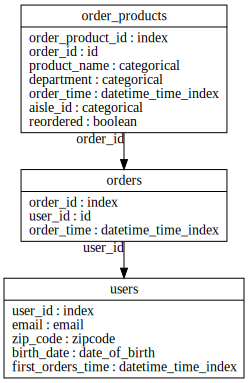

In [3]:
es.plot()

## Step 2. Make Labels

For supervised machine learning, we need labels. These labels define what our predictive model will be used for. In this tutorial, we will predict if a customer will buy Bananas in the next 4 weeks.

We generate training examples by selecting a `cutoff_time` in the past to make our labels. Using users who had acivity during `training_window` days before the `cutoff_time`, we look to see if they purchase the product in the `prediction_window`. 

If you are running this code yourself, feel free to experiment with any of these parameters! For example, try to predict if a customer will buy "Limes" instead of "Bananas" or increase the size of your `prediction_window`.

In [4]:
def make_labels(es, training_window, cutoff_time,
                product_name, prediction_window):

    prediction_window_end = cutoff_time + prediction_window
    t_start = cutoff_time - training_window

    orders = es["orders"].df
    ops = es["order_products"].df

    training_data = ops[(ops["order_time"] <= cutoff_time) & (ops["order_time"] > t_start)]
    prediction_data = ops[(ops["order_time"] > cutoff_time) & (ops["order_time"] < prediction_window_end)]

    users_in_training = training_data.merge(orders)["user_id"].unique()

    valid_pred_data = prediction_data.merge(orders)
    valid_pred_data = valid_pred_data[valid_pred_data["user_id"].isin(users_in_training)]

    def bought_product(df):
        return (df["product_name"] == product_name).any()

    labels = valid_pred_data.groupby("user_id").apply(bought_product).reset_index()
    labels["cutoff_time"] = cutoff_time
    #  rename and reorder
    labels.columns = ["user_id", "label", "time",]
    labels = labels[["user_id", "time", "label"]]

    return labels

In [5]:
label_times = make_labels(es=es,
                          product_name = "Banana",
                          cutoff_time = pd.Timestamp('March 15, 2015'),
                          prediction_window = ft.Timedelta("4 weeks"),
                          training_window = ft.Timedelta("60 days"))
label_times.head(5)

,user_id,time,label
0,1001,2015-03-15,False
1,1002,2015-03-15,False
2,1003,2015-03-15,False
3,1004,2015-03-15,False
4,1005,2015-03-15,False


We can see above the our training examples contain three pieces of information: a user id, the last time we can use data before feature engineering (called the "cutoff time"), and the label to predict. These are called our "label times".

The distribution of the labels

In [6]:
label_times["label"].value_counts()

False    654
True     128
Name: label, dtype: int64

## 3. Automated Feature Engineering
With our label times in hand, we can use Deep Feature Synthesis to automatically generate features.

When we use DFS, we specify

* `target_entity` - the table to build feature for
* `cutoff_time` the point in time to calculate the features
* `training_window` - the amount of historical data we want to use when calculating features

A good way to think of the `cutoff_time` is that it let's us "pretend" we are at an earlier point in time when generating our features so we can simulate making predictions. We get this time for each customer from the label times we generated above.

The **users** entity has some specialized variable types (DateOfBirth, Email, and ZIPCode):

In [7]:
es["users"]

Entity: users
  Variables:
    user_id (dtype: index)
    email (dtype: email)
    zip_code (dtype: zipcode)
    birth_date (dtype: date_of_birth)
    first_orders_time (dtype: datetime_time_index)
  Shape:
    (Rows: 1000, Columns: 5)

Premium Primitives we can utilize:
* Age-based primitives ([Age](https://primitives.featurelabs.com/#Age), [Age is over 18](https://primitives.featurelabs.com/#AgeOver18), [Age is over 25](https://primitives.featurelabs.com/#AgeOver25), [Age is over 65](https://primitives.featurelabs.com/#AgeOver65)) - the types of purchases made by customers could shift based on their age
* [Free email domain](https://primitives.featurelabs.com/#IsFreeEmailDomain) - using a non-free email could be a sign of different user segment or a business account
* [Zip code to household income](https://primitives.featurelabs.com/#ZIPCodeToHouseholdIncome), [Zip code to per capita income](https://primitives.featurelabs.com/#ZIPCodeToPerCapitaIncome) - economic data on the user's location could be predictive of their spending habits
* [Zip code to state](https://primitives.featurelabs.com/#ZIPCodeToState) - group the users into a larger geographic group than zip code
* [Number of days to specific holiday](https://primitives.featurelabs.com/#DistanceToHoliday) - holiday-themed items are more likely to be purchased around their holiday
* [Season of the year](https://primitives.featurelabs.com/#Season) - some grocery purchase patterns may vary by season
* [Time of day](https://primitives.featurelabs.com/#PartOfDay) - the types of groceries ordered may vary based on the time at which the order was placed (morning, afternoon, evening, or night)
* [Is it a federal holiday](https://primitives.featurelabs.com/#IsFederalHoliday) - customer purchasing patterns may shift on holidays

We'll add these to the standard featuretools transform primitives

In [8]:
from featuretools.primitives import DistanceToHoliday

trans_primitives = [
    "age", "age_over_18", "age_over_25", "age_over_65", "is_free_email_domain",
    "zipcode_to_state", "year", "month", "zipcode_to_per_capita_income", "day",
    "haversine", "num_words", "zipcode_to_household_income", "season",
    "zipcode_to_latlong", "weekday", "num_characters", "part_of_day", 
    "is_federal_holiday", DistanceToHoliday("Christmas Day"),
    DistanceToHoliday('Independence Day')
]

feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"), # same as above
                                  trans_primitives=trans_primitives,
                                  entityset=es,
                                  cutoff_time_in_index=True,
                                  verbose=True)

Built 98 features
Elapsed: 00:13 | Progress: 100%|██████████


In [9]:
features

[<Feature: zip_code>,
 <Feature: COUNT(orders)>,
 <Feature: COUNT(order_products)>,
 <Feature: PERCENT_TRUE(order_products.reordered)>,
 <Feature: NUM_UNIQUE(order_products.product_name)>,
 <Feature: NUM_UNIQUE(order_products.department)>,
 <Feature: NUM_UNIQUE(order_products.aisle_id)>,
 <Feature: MODE(order_products.product_name)>,
 <Feature: MODE(order_products.department)>,
 <Feature: MODE(order_products.aisle_id)>,
 <Feature: AGE(birth_date)>,
 <Feature: AGE_OVER_18(birth_date)>,
 <Feature: AGE_OVER_25(birth_date)>,
 <Feature: AGE_OVER_65(birth_date)>,
 <Feature: IS_FREE_EMAIL_DOMAIN(email)>,
 <Feature: ZIPCODE_TO_STATE(zip_code)>,
 <Feature: YEAR(birth_date)>,
 <Feature: YEAR(first_orders_time)>,
 <Feature: MONTH(birth_date)>,
 <Feature: MONTH(first_orders_time)>,
 <Feature: ZIPCODE_TO_PER_CAPITA_INCOME(zip_code)>,
 <Feature: DAY(birth_date)>,
 <Feature: DAY(first_orders_time)>,
 <Feature: ZIPCODE_TO_HOUSEHOLD_INCOME(zip_code)>,
 <Feature: SEASON(birth_date)>,
 <Feature: SEASON(f

In [10]:
# encode categorical values
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)

## Step 4. Machine Learning

Using the default parameters, we generated 160 potential features for our prediction problem. With a few simple commands, this feature matrix can be used for machine learning

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy="mean")
estimator = RandomForestClassifier(n_estimators=400,
                                   n_jobs=-1)

pipeline = Pipeline(
    [("imputer", imputer),
     ("estimator", estimator)]
)

In [12]:
X = fm_encoded.reset_index()
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("label")

In [13]:
X

,zip_code = 97007,zip_code = 97005,zip_code = 94303,zip_code = 94605,zip_code = 94302,zip_code = 94602,zip_code = 94304,zip_code = 94301,zip_code = 94603,zip_code = 94601,...,MODE(order_products.orders.user_id) = 1998,MODE(order_products.orders.user_id) = 1997,MODE(order_products.orders.user_id) = 1996,MODE(order_products.orders.user_id) = 1994,MODE(order_products.orders.user_id) = 1993,MODE(order_products.orders.user_id) = 1992,MODE(order_products.orders.user_id) = 1991,MODE(order_products.orders.user_id) = 1990,MODE(order_products.orders.user_id) = 1989,MODE(order_products.orders.user_id) is unknown
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
778,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
779,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
780,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
y

0      False
1      False
2      False
3      False
4      False
       ...  
777    False
778    False
779     True
780    False
781    False
Name: label, Length: 782, dtype: bool

Let's train a Random Forest and validate using 3-fold cross validation

In [15]:
from sklearn.model_selection import StratifiedKFold

# perform cross validation
cv = StratifiedKFold(n_splits=3)
scores = []
for train, test in cv.split(X, y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    scores.append(score)
    
np.mean(scores), np.std(scores)

(0.8452745849297574, 0.004577256944433578)

In [16]:
# fit on all data and get importances
pipeline = pipeline.fit(X, y)

importances = zip(X.columns, pipeline["estimator"].feature_importances_)
df = pd.DataFrame(importances, columns=["feature", "importance"])
df = df.sort_values("importance", ascending=False)
df.head(20)

,feature,importance
17,MODE(order_products.product_name) = Banana,0.043154
181,MODE(orders.MODE(order_products.product_name))...,0.030227
136,STD(orders.PERCENT_TRUE(order_products.reorder...,0.017696
50,AGE(birth_date),0.017572
165,MEAN(orders.NUM_UNIQUE(order_products.product_...,0.017522
167,MEAN(orders.NUM_UNIQUE(order_products.aisle_id)),0.017352
163,MEAN(orders.COUNT(order_products)),0.017053
12,COUNT(order_products),0.015845
14,NUM_UNIQUE(order_products.product_name),0.015674
141,"STD(orders.DISTANCE_TO_HOLIDAY(order_time, hol...",0.015545


We can see we perform noticably better than guessing! However, we have a pretty high difference in performance accross folds.

To improve this, let's identify the top 20 features using a Random Forest and then perform machine learning on the whole dataset (all of the partions).

### Understanding feature engineering in Featuretools

Before moving forward, take a look at the feature we created. You will see that they are more than just simple transformations of columns in our raw data. Instead, they aggregations (and sometimes stacking of aggregations) across the relationships in our dataset. If you're curious how this works, learn about the Deep Feature Synthesis algorithm in our documentation [here](https://docs.featuretools.com/automated_feature_engineering/afe.html).

DFS is so powerful because with no manual work, the library figured out that historical purchases of bananas are important for predicting future purchases. Additionally, it surfaces that purchasing dairy or eggs and reordering behavior are important features. 

Even though these features are intuitive, Deep Feature Synthesis will automatically adapt as we change the prediction problem, saving us the time of manually brainstorming and implementing these data transformation. 

## Next Steps

While this is an end-to-end example of going from raw data to a trained machine learning model, it is necessary to do further exploration before claiming we've built something impact full.

Fortunately, Featuretools makes it easy to build structured data science pipeline. As a next steps, you could
* Further validate these results by creating feature vectors at different cutoff times
* Define other prediction problems for this dataset (you can even change the entity you are making predictions on!)
* Save feature matrices to disk as CSVs so they can be reused with different problems without recalculating
* Experiment with parameters to Deep Feature Synthesis
* Create custom primitives for DFS. More info [here](https://docs.featuretools.com/automated_feature_engineering/primitives.html).

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>


Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact).